*Original code: Beating the Benchmark from West Nile Virus Prediction @ Kaggle by Abhihsek. Modified by Brendan Lane*

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import Adam
from keras.initializers import *

%matplotlib inline

In [3]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [4]:
# Load dataset 
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
sample = pd.read_csv('../assets/sampleSubmission.csv')
weather = pd.read_csv('../assets/weather.csv')

In [5]:
# Not using codesum for this benchmark
weather.drop('CodeSum', axis='columns', inplace=True)

In [6]:
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

In [7]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [8]:
# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_year(x):
    return x.split('-')[0]
def create_month(x):
    return x.split('-')[1]
def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
train['year'] = train.Date.apply(create_year)

test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)
test['year'] = test.Date.apply(create_year)

In [9]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [10]:
# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)

In [11]:
# Convert categorical data to numbers
lbl = LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

In [12]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [13]:
# covert all data types to floats
train = train.astype(float)
test = test.astype(float)

In [14]:
## feature engineering
# Temperature difference
train['temp_delta_x'] = train.Tmax_x - train.Tmin_x
train['temp_delta_y'] = train.Tmax_y - train.Tmin_y
train['temp_delta_x'] = train.Tmax_x - train.Tmin_x
train['temp_delta_y'] = train.Tmax_y - train.Tmin_y
test['temp_delta_x'] = test.Tmax_x - test.Tmin_x
test['temp_delta_y'] = test.Tmax_y - test.Tmin_y
test['temp_delta_x'] = test.Tmax_x - test.Tmin_x
test['temp_delta_y'] = test.Tmax_y - test.Tmin_y

In [15]:
# Is raining?
train['israining_x'] = (train.PrecipTotal_x > 0).astype(int)
train['israining_y'] = (train.PrecipTotal_y > 0).astype(int)
test['israining_x'] = (test.PrecipTotal_x > 0).astype(int)
test['israining_y'] = (test.PrecipTotal_y > 0).astype(int)

In [16]:
# Length of sunlight
train['sunlight'] = train.Sunset_x - train.Sunrise_x
test['sunlight'] = test.Sunset_x - test.Sunrise_x

In [17]:
# Replace outliers with median value
train.WetBulb_x = train.WetBulb_x.apply(lambda x: train.WetBulb_x.median() if x < 0 else x)
test.WetBulb_x = test.WetBulb_x.apply(lambda x: test.WetBulb_x.median() if x < 0 else x)

train.StnPressure_x = train.StnPressure_x.apply(lambda x: train.StnPressure_x.median() if x < 0 else x)
test.StnPressure_x = test.StnPressure_x.apply(lambda x: test.StnPressure_x.median() if x < 0 else x)

In [18]:
# Relative humidity approximation
train['RH'] = 100 - (25 / 9) * (train.Tavg_x - train.DewPoint_x)
test['RH'] = 100 - (25 / 9) * (test.Tavg_x - test.DewPoint_x)

In [19]:
# Is heat wave?
train['isheat'] = (train.Heat_x > 0).astype(float)
test['isheat'] = (test.Heat_x > 0).astype(float)

In [20]:
# Vectorize resultant wind into north and east components
wind_dir_north_x = train.ResultDir_x.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_x = train.ResultDir_x.apply(lambda x: np.cos(np.deg2rad(x)))
train['wind_north_x'] = wind_dir_north_x * train.ResultSpeed_x
train['wind_east_x'] = wind_dir_east_x * train.ResultSpeed_x

wind_dir_north_y = train.ResultDir_y.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_y = train.ResultDir_y.apply(lambda x: np.cos(np.deg2rad(x)))
train['wind_north_y'] = wind_dir_north_y * train.ResultSpeed_y
train['wind_east_y'] = wind_dir_east_y * train.ResultSpeed_y

wind_dir_north_x = test.ResultDir_x.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_x = test.ResultDir_x.apply(lambda x: np.cos(np.deg2rad(x)))
test['wind_north_x'] = wind_dir_north_x * test.ResultSpeed_x
test['wind_east_x'] = wind_dir_east_x * test.ResultSpeed_x

wind_dir_north_y = test.ResultDir_y.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_y = test.ResultDir_y.apply(lambda x: np.cos(np.deg2rad(x)))
test['wind_north_y'] = wind_dir_north_y * test.ResultSpeed_y
test['wind_east_y'] = wind_dir_east_y * test.ResultSpeed_y

In [21]:
# Vectorize average wind into north and east components
train['avg_wind_north_x'] = wind_dir_north_x * train.AvgSpeed_x
train['avg_wind_east_x'] = wind_dir_east_x * train.AvgSpeed_x

train['avg_wind_north_y'] = wind_dir_north_y * train.AvgSpeed_y
train['avg_wind_east_y'] = wind_dir_east_y * train.AvgSpeed_y

test['avg_wind_north_x'] = wind_dir_north_x * test.AvgSpeed_x
test['avg_wind_east_x'] = wind_dir_east_x * test.AvgSpeed_x

test['avg_wind_north_y'] = wind_dir_north_y * test.AvgSpeed_y
test['avg_wind_east_y'] = wind_dir_east_y * test.AvgSpeed_y

In [22]:
# train = pd.concat([train.reset_index(), (pd.get_dummies(train.year)).reset_index(), (pd.get_dummies(train.month)).reset_index(), (pd.get_dummies(train.Species)).reset_index()], axis='columns')
# test = pd.concat([test.reset_index(), (pd.get_dummies(test.year)).reset_index(), (pd.get_dummies(test.month)).reset_index(), (pd.get_dummies(test.Species)).reset_index()], axis='columns')

In [23]:
train = pd.get_dummies(train, columns=['Species'], drop_first=True)
test = pd.get_dummies(test, columns=['Species'], drop_first=True)

In [24]:
drop_list = ['PrecipTotal_x', 'PrecipTotal_y', 'Sunrise_x', 'Sunset_x',
             'Heat_x', 'Depth_x', 'SnowFall_x', 'ResultDir_x', 'ResultSpeed_x',
             'ResultDir_y', 'ResultSpeed_y', 'AvgSpeed_x', 'AvgSpeed_y', 'year',
             'month', 'day']

train.drop(drop_list + ['NumMosquitos'], axis='columns', inplace=True)
test.drop(drop_list + ['Species_7.0'], axis='columns', inplace=True)

In [25]:
# Set dependent (y) and indepedent (X) variables
y = train.WnvPresent
X = train.drop('WnvPresent', axis='columns')

In [26]:
# Baseline accuracy
1 - y.mean()

0.9475537787930707

In [27]:
# Scale X for modeling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [28]:
# Train/test split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# Random forest
cross_val_score(RandomForestClassifier(max_depth=4, max_features=5), X_train, y_train,
                cv=5, n_jobs=-1, verbose=0).mean()

0.9475250626167533

*Doesn't break baseline. What is happening?*

In [48]:
# Confustion matrix
clf = RandomForestClassifier(max_depth=4, max_features=5)
clf.fit(X_train, y_train)
confusion_matrix(y_test, clf.predict(X_test))

array([[1992,    0],
       [ 110,    0]])

*The model is maximizing accuracy by predicting "No" everytime. This is the result of have unbalanced classes.*

In [31]:
# Oversampled train/test split
yo = train.WnvPresent.values
Xo = train
X_traino, X_testo, y_traino, y_testo = train_test_split(Xo, yo, test_size=0.2, stratify=yo)
X_traino = pd.DataFrame(scaler.fit_transform(X_traino), columns=X_traino.columns)
X_testo = pd.DataFrame(scaler.fit_transform(X_testo), columns=X_testo.columns)

In [32]:
# Dataframe of positive West Nile results
pos_train = X_traino[X_traino.WnvPresent > 0]

In [33]:
# Oversampled unrepresented class
l = pos_train.shape[0]
X_traino = pd.concat([X_traino, pos_train], axis=0)
for _ in range(10):
    X_traino = pd.concat([X_traino, pos_train], axis=0)
y_traino = X_traino.WnvPresent.values
y_traino = np.array([1 * (x > 0) for x in y_traino])
X_traino = X_traino.drop('WnvPresent', axis='columns')
X_testo = X_testo.drop('WnvPresent', axis='columns')

In [34]:
print(X_traino.shape[0] - l)
print(y_traino.shape[0] - l)
l

12814
12814


441

In [35]:
y_traino

array([0, 0, 0, ..., 1, 1, 1])

### We need to maximize recall

In [36]:
clf = RandomForestClassifier(max_depth=4, max_features=7)
clf.fit(X_traino, y_traino)
print(confusion_matrix(y_testo, clf.predict(X_testo)))
print(classification_report(y_testo, clf.predict(X_testo), target_names=['No', 'Yes']))

[[1628  364]
 [  39   71]]
             precision    recall  f1-score   support

         No       0.98      0.82      0.89      1992
        Yes       0.16      0.65      0.26       110

avg / total       0.93      0.81      0.86      2102



In [37]:
roc_auc_score(y_testo, clf.predict_proba(X_testo)[:,1])

0.8103368017524644

In [38]:
logreg = LogisticRegression()
logreg.fit(X_traino, y_traino)
logreg.score(X_testo, y_testo)

0.7849666983824929

In [39]:
roc_auc_score(y_testo, logreg.predict_proba(X_testo)[:,1])

0.8017091091639283

In [47]:
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_traino, y_traino)
    print(roc_auc_score(y_testo, knn.predict_proba(X_testo)[:,1]))

0.6078587075575027
0.6354098211025923
0.6626551661190215
0.6872261774370209
0.6933598028477547
0.6977774735304857
0.7073156261409274
0.7253719423147135
0.7342141292442498
0.7395376962395034
0.7379586527929901
0.7376985213581599
0.7398525921869297
0.7390014603870025
0.7393049470609712
0.7416689485213582
0.7450848849945235
0.7486902154070829
0.749977181453085


In [45]:
confusion_matrix(y_testo, logreg.predict(X_testo))

array([[1578,  414],
       [  38,   72]])

In [401]:
np.random.seed()

In [450]:
model = Sequential()
input_units = X_train.shape[1]
hidden_units = input_units

model.add(Dense(hidden_units * 2,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(hidden_units * 2,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [452]:
%%time
hist = model.fit(X_traino, y_traino,
                 validation_data=(X_testo, y_testo),
                 epochs=100,
#                  batch_size=64,
                 shuffle=True)

Train on 13255 samples, validate on 2102 samples
Epoch 1/100
13255/13255 [==============================] - 2s 121us/step - loss: 0.5674 - acc: 0.6939 - val_loss: 0.3836 - val_acc: 0.8268
Epoch 2/100
13255/13255 [==============================] - 1s 61us/step - loss: 0.4895 - acc: 0.7578 - val_loss: 0.4107 - val_acc: 0.7878
Epoch 3/100
13255/13255 [==============================] - 1s 60us/step - loss: 0.4586 - acc: 0.7719 - val_loss: 0.4005 - val_acc: 0.7788
Epoch 4/100
13255/13255 [==============================] - 1s 72us/step - loss: 0.4389 - acc: 0.7783 - val_loss: 0.3772 - val_acc: 0.7778
Epoch 5/100
13255/13255 [==============================] - 1s 77us/step - loss: 0.4260 - acc: 0.7891 - val_loss: 0.3381 - val_acc: 0.7897
Epoch 6/100
13255/13255 [==============================] - 1s 77us/step - loss: 0.4147 - acc: 0.7923 - val_loss: 0.3513 - val_acc: 0.7783
Epoch 7/100
13255/13255 [==============================] - 1s 80us/step - loss: 0.4017 - acc: 0.8044 - val_loss: 0.3821 - 

13255/13255 [==============================] - 1s 75us/step - loss: 0.2349 - acc: 0.9017 - val_loss: 0.3962 - val_acc: 0.8411
Epoch 60/100
13255/13255 [==============================] - 1s 85us/step - loss: 0.2415 - acc: 0.8975 - val_loss: 0.3899 - val_acc: 0.8468
Epoch 61/100
13255/13255 [==============================] - 1s 62us/step - loss: 0.2370 - acc: 0.8993 - val_loss: 0.3983 - val_acc: 0.8473
Epoch 62/100
13255/13255 [==============================] - 1s 71us/step - loss: 0.2411 - acc: 0.8971 - val_loss: 0.3827 - val_acc: 0.8506
Epoch 63/100
13255/13255 [==============================] - 1s 67us/step - loss: 0.2384 - acc: 0.8993 - val_loss: 0.3804 - val_acc: 0.8492
Epoch 64/100
13255/13255 [==============================] - 1s 58us/step - loss: 0.2362 - acc: 0.8994 - val_loss: 0.4000 - val_acc: 0.8468
Epoch 65/100
13255/13255 [==============================] - 1s 58us/step - loss: 0.2366 - acc: 0.9012 - val_loss: 0.3817 - val_acc: 0.8520
Epoch 66/100
13255/13255 [==============

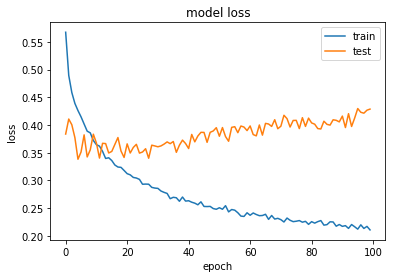

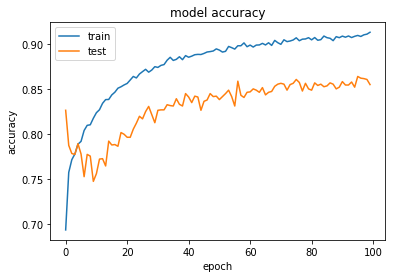

0.8553758326538623

In [453]:
train_loss += hist.history['loss']
test_loss += hist.history['val_loss']
train_acc += hist.history['acc']
test_acc += hist.history['val_acc']

plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
plt.show()
plt.figure()
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
test_acc[-1]

In [474]:
roc_auc_score(y_testo, model.predict(X_testo))

0.7971613727637824

In [235]:
roc_curve(y_test, model.predict(X_test))

(array([0.        , 0.        , 0.00100402, 0.00100402, 0.00150602,
        0.00150602, 0.00150602, 0.00200803, 0.00200803, 0.00301205,
        0.00301205, 0.00351406, 0.00351406, 0.00401606, 0.00401606,
        0.00502008, 0.00502008, 0.00502008, 0.00502008, 0.00702811,
        0.00702811, 0.00753012, 0.00753012, 0.00853414, 0.00903614,
        0.00903614, 0.01154618, 0.01154618, 0.01204819, 0.01204819,
        0.01305221, 0.01355422, 0.01455823, 0.01455823, 0.01556225,
        0.01556225, 0.01606426, 0.01606426, 0.01656627, 0.01656627,
        0.01706827, 0.01757028, 0.01757028, 0.02158635, 0.02158635,
        0.02409639, 0.02409639, 0.02459839, 0.02459839, 0.02560241,
        0.02560241, 0.02610442, 0.02610442, 0.02811245, 0.02911647,
        0.02961847, 0.03062249, 0.03162651, 0.03263052, 0.03413655,
        0.03614458, 0.03714859, 0.0376506 , 0.03815261, 0.04016064,
        0.04016064, 0.04066265, 0.04066265, 0.04166667, 0.04166667,
        0.04317269, 0.04317269, 0.0436747 , 0.04

In [244]:
for threshold in np.linspace(0, 1, 101):
    print('Threshold: {}'.format(threshold))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, (model.predict(X_test) > threshold).astype(float)))
    print(classification_report(y_test, (model.predict(X_test) > threshold).astype(float), target_names=['No', 'Yes']))
    print('*******************************\n')

Threshold: 0.0
Confusion Matrix
[[ 201 1791]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.10      0.18      1992
        Yes       0.06      1.00      0.11       110

avg / total       0.95      0.15      0.18      2102

*******************************

Threshold: 0.01
Confusion Matrix
[[1503  489]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.75      0.86      1992
        Yes       0.18      1.00      0.31       110

avg / total       0.96      0.77      0.83      2102

*******************************

Threshold: 0.02
Confusion Matrix
[[1561  431]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.78      0.88      1992
        Yes       0.20      1.00      0.34       110

avg / total       0.96      0.79      0.85      2102

*******************************

Threshold: 0.03
Confusion Matrix
[[1589  403]
 [   0  110]]
             prec

[[1730  262]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.87      0.93      1992
        Yes       0.30      1.00      0.46       110

avg / total       0.96      0.88      0.90      2102

*******************************

Threshold: 0.3
Confusion Matrix
[[1730  262]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.87      0.93      1992
        Yes       0.30      1.00      0.46       110

avg / total       0.96      0.88      0.90      2102

*******************************

Threshold: 0.31
Confusion Matrix
[[1734  258]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.87      0.93      1992
        Yes       0.30      1.00      0.46       110

avg / total       0.96      0.88      0.91      2102

*******************************

Threshold: 0.32
Confusion Matrix
[[1736  256]
 [   0  110]]
             precision    recall  f1-score   suppo

[[1823  169]
 [   5  105]]
             precision    recall  f1-score   support

         No       1.00      0.92      0.95      1992
        Yes       0.38      0.95      0.55       110

avg / total       0.97      0.92      0.93      2102

*******************************

Threshold: 0.59
Confusion Matrix
[[1824  168]
 [   5  105]]
             precision    recall  f1-score   support

         No       1.00      0.92      0.95      1992
        Yes       0.38      0.95      0.55       110

avg / total       0.97      0.92      0.93      2102

*******************************

Threshold: 0.6
Confusion Matrix
[[1826  166]
 [   5  105]]
             precision    recall  f1-score   support

         No       1.00      0.92      0.96      1992
        Yes       0.39      0.95      0.55       110

avg / total       0.97      0.92      0.93      2102

*******************************

Threshold: 0.61
Confusion Matrix
[[1827  165]
 [   6  104]]
             precision    recall  f1-score   suppo

[[1932   60]
 [  38   72]]
             precision    recall  f1-score   support

         No       0.98      0.97      0.98      1992
        Yes       0.55      0.65      0.60       110

avg / total       0.96      0.95      0.96      2102

*******************************

Threshold: 0.87
Confusion Matrix
[[1935   57]
 [  41   69]]
             precision    recall  f1-score   support

         No       0.98      0.97      0.98      1992
        Yes       0.55      0.63      0.58       110

avg / total       0.96      0.95      0.95      2102

*******************************

Threshold: 0.88
Confusion Matrix
[[1941   51]
 [  41   69]]
             precision    recall  f1-score   support

         No       0.98      0.97      0.98      1992
        Yes       0.57      0.63      0.60       110

avg / total       0.96      0.96      0.96      2102

*******************************

Threshold: 0.89
Confusion Matrix
[[1941   51]
 [  42   68]]
             precision    recall  f1-score   supp

/Users/evankranzler/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [237]:
y_testo.mean()

0.3992154496077248

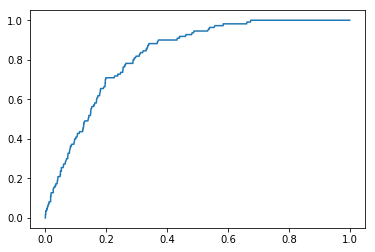

In [473]:
sens = []
spec = []
most_goodest = []
# pred = clf.predict_proba(X_testo)[:,1]
pred = logreg.predict_proba(X_testo)[:,1]
for n in np.linspace(0, 1, 1001):
    temp = 1 * (pred > n)
    tn, fp, fn, tp = confusion_matrix(y_testo, temp).ravel()
    sens += [tp / (tp + fn)]
    spec += [1 - (tn / (tn + fp))]
    most_goodest += [tp + tn]
# sens += [0]
# spec += [0]
plt.plot(spec, sens);
plt.show()
# plt.plot(np.linspace(0, 1, 1001), most_goodest)
# plt.show()

In [417]:
len(clf.predict_proba(X_traino)[:,1])

13255

In [419]:
len(y_testo)

2102

In [106]:
max([x for x in zip(most_goodest, np.linspace(0, 1, 10001))])

(2037, 0.9792000000000001)

In [46]:
temp = 1 * (pred > .9792)
tn, fp, fn, tp = confusion_matrix(y_test, temp).ravel()
tn, fp, fn, tp

(1984, 8, 86, 24)

In [75]:
mat[0][1]

120

In [91]:
np.linspace(0, 1, 1001)

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [112]:
sample.WnvPresent

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
116263    0
116264    0
116265    0
116266    0
116267    0
116268    0
116269    0
116270    0
116271    0
116272    0
116273    0
116274    0
116275    0
116276    0
116277    0
116278    0
116279    0
116280    0
116281    0
116282    0
116283    0
116284    0
116285    0
116286    0
116287    0
116288    0
116289    0
116290    0
116291    0
116292    0
Name: WnvPresent, Length: 116293, dtype: int64

In [269]:
preds = model.predict(scaler.transform(test))
submission = pd.DataFrame([[i + 1, x[0]] for i, x in enumerate(preds.tolist())], columns=sample.columns)

In [270]:
submission.to_csv('submission.csv',index=False)

In [271]:
submission

,Id,WnvPresent
0,1,7.074654e-18
1,2,2.140841e-32
2,3,9.462343e-19
3,4,0.000000e+00
4,5,0.000000e+00
5,6,0.000000e+00
6,7,5.558945e-15
7,8,5.558945e-15
8,9,4.147224e-23
9,10,7.807513e-33


In [86]:
exclusions = [x for x in train.columns if x not in test.columns] + [x for x in test.columns if x not in train.columns]

In [87]:
exclusions

['NumMosquitos', 'WnvPresent', 'Id']

In [160]:
beep = train.drop(columns=exclusions)
boop = test.drop(columns=exclusions)

In [178]:
boop.index

RangeIndex(start=0, stop=116293, step=1)

In [193]:
trainer = train.drop(columns='WnvPresent')

In [194]:
trainer.columns

Index(['Block', 'Street', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x', 'WetBulb_x',
       'Cool_x', 'StnPressure_x', 'SeaLevel_x', 'Tmax_y', 'Tmin_y', 'Tavg_y',
       'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y', 'StnPressure_y',
       'SeaLevel_y', 'temp_delta_x', 'temp_delta_y', 'israining_x',
       'israining_y', 'sunlight', 'RH', 'isheat', 'wind_north_x',
       'wind_east_x', 'wind_north_y', 'wind_east_y', 'avg_wind_north_x',
       'avg_wind_east_x', 'avg_wind_north_y', 'avg_wind_east_y', 'Species_1.0',
       'Species_2.0', 'Species_3.0', 'Species_4.0', 'Species_5.0',
       'Species_6.0'],
      dtype='object')

In [189]:
test.columns

Index(['Block', 'Street', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x', 'WetBulb_x',
       'Cool_x', 'StnPressure_x', 'SeaLevel_x', 'Tmax_y', 'Tmin_y', 'Tavg_y',
       'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y', 'StnPressure_y',
       'SeaLevel_y', 'temp_delta_x', 'temp_delta_y', 'israining_x',
       'israining_y', 'sunlight', 'RH', 'isheat', 'wind_north_x',
       'wind_east_x', 'wind_north_y', 'wind_east_y', 'avg_wind_north_x',
       'avg_wind_east_x', 'avg_wind_north_y', 'avg_wind_east_y', 'Species_1.0',
       'Species_2.0', 'Species_3.0', 'Species_4.0', 'Species_5.0',
       'Species_6.0', 'Species_7.0'],
      dtype='object')

In [196]:
[x for x,y in zip(trainer.columns, test.columns) if x==y]

['Block',
 'Street',
 'Trap',
 'Latitude',
 'Longitude',
 'AddressAccuracy',
 'Tmax_x',
 'Tmin_x',
 'Tavg_x',
 'Depart_x',
 'DewPoint_x',
 'WetBulb_x',
 'Cool_x',
 'StnPressure_x',
 'SeaLevel_x',
 'Tmax_y',
 'Tmin_y',
 'Tavg_y',
 'DewPoint_y',
 'WetBulb_y',
 'Heat_y',
 'Cool_y',
 'StnPressure_y',
 'SeaLevel_y',
 'temp_delta_x',
 'temp_delta_y',
 'israining_x',
 'israining_y',
 'sunlight',
 'RH',
 'isheat',
 'wind_north_x',
 'wind_east_x',
 'wind_north_y',
 'wind_east_y',
 'avg_wind_north_x',
 'avg_wind_east_x',
 'avg_wind_north_y',
 'avg_wind_east_y',
 'Species_1.0',
 'Species_2.0',
 'Species_3.0',
 'Species_4.0',
 'Species_5.0',
 'Species_6.0']